In [2]:
import os, time
from pathlib import Path
from operator import add
import numpy as np
from glob import glob
import glob
import cv2
from tqdm import tqdm
import imageio
import torch
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score

from unet import build_unet
from utils import create_dir, seeding, sort_path_list



def calculate_metrics(y_true, y_pred,threshold):
    # Ground truth
    y_true = y_true.cpu().numpy()
    y_true = y_true > threshold
    y_true = y_true.astype(np.uint8)
    y_true = y_true.reshape(-1)

    # Prediction
    y_pred = y_pred.cpu().numpy()
    y_pred = y_pred > threshold
    y_pred = y_pred.astype(np.uint8)
    y_pred = y_pred.reshape(-1)

    score_jaccard = jaccard_score(y_true, y_pred)
    score_f1 = f1_score(y_true, y_pred)
    score_recall = recall_score(y_true, y_pred)
    score_precision = precision_score(y_true, y_pred)
    score_acc = accuracy_score(y_true, y_pred)

    return [score_jaccard, score_f1, score_recall, score_precision, score_acc]

def mask_parse(mask):
    mask = np.expand_dims(mask, axis=-1)    ## (512, 512, 1)
    mask = np.concatenate([mask, mask, mask], axis=-1)  ## (512, 512, 3)
    return mask

if __name__ == "__main__":
    
    #threshold
    threshold=0.8
    # Seeding
    seeding(42)

    # Directories

    base_path = Path.cwd().parent
    create_dir(base_path / "results")

    #Clean the 'results' dir - optional
    dir = (base_path / "results")
    filelist = glob.glob(os.path.join(dir, "*"))
    #for f in filelist:
        #os.remove(f)

    # Load dataset
    test_x = list((base_path / "new_data/test/images/").glob("*.jpeg"))
    test_y = list((base_path / "new_data/test/masks/").glob("*.jpeg"))
    
    test_x.sort(key=sort_path_list)
    test_y.sort(key=sort_path_list)

    # Hyperparameters
    H = 128
    W = 128
    size = (W, H)
    checkpoint_path = base_path / "models/roof_surface_model_B60_E100_lr1.000e-03_L4_Adam_DiceBCE.pth"

    # Load checkpoint
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = build_unet()
    model = model.to(device)
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.eval()

    metrics_score = [0.0, 0.0, 0.0, 0.0, 0.0]
    time_taken = []
    pred_y_plot=[]
    img_plot=[]
    mask_plot=[]

    for i, (x_file, y_file) in tqdm(enumerate(zip(test_x, test_y)), total=len(test_x)):
        # Extract the name
        x_filename = x_file.stem
        y_filename = y_file.stem

        """ Reading image """
        image = cv2.imread(str(x_file), cv2.IMREAD_COLOR) ## (512, 512, 3)
        x = np.transpose(image, (2, 0, 1))      ## (3, 512, 512)
        x = x/255.0
        x = np.expand_dims(x, axis=0)           ## (1, 3, 512, 512)
        x = x.astype(np.float32)
        x = torch.from_numpy(x)
        x = x.to(device)


        """ Reading mask """
        mask = cv2.imread(str(y_file), cv2.IMREAD_GRAYSCALE)  ## (512, 512)
        y = np.expand_dims(mask, axis=0)            ## (1, 512, 512)
        y = y/255.0
        y = np.expand_dims(y, axis=0)               ## (1, 1, 512, 512)
        y = y.astype(np.float32)
        y = torch.from_numpy(y)
        y = y.to(device)

        with torch.no_grad():
            """ Prediction and Calculating FPS """
            start_time = time.time()
            pred_y = model(x)
            #pred_y = torch.nn.Softmax(pred_y)
            pred_y = torch.sigmoid(pred_y)
            total_time = time.time() - start_time
            time_taken.append(total_time)


            score = calculate_metrics(y, pred_y, threshold)
            metrics_score = list(map(add, metrics_score, score))
            pred_y = pred_y[0].cpu().numpy()        ## (1, 512, 512)
            pred_y = np.squeeze(pred_y, axis=0)
            #for ploting

            pred_y_plot.append(pred_y)
            img_plot.append(image)
            
            
            pred_y = pred_y > threshold
            pred_y = np.array(pred_y, dtype=np.uint8)



        """ Saving masks """
        ori_mask = mask_parse(mask)
        
        mask_plot.append(ori_mask)
        
        pred_y = mask_parse(pred_y)
        line = np.ones((size[1], 10, 3)) * 128
        
        
        cat_images = np.concatenate(
            [image, line, ori_mask, line, pred_y * 255], axis=1
        )
        
        cv2.imwrite(f"results/{x_filename}.png", cat_images)

    jaccard = metrics_score[0]/len(test_x)
    f1 = metrics_score[1]/len(test_x)
    recall = metrics_score[2]/len(test_x)
    precision = metrics_score[3]/len(test_x)
    acc = metrics_score[4]/len(test_x)
    print(f"Jaccard: {jaccard:1.4f} - F1: {f1:1.4f} - Recall: {recall:1.4f} - Precision: {precision:1.4f} - Acc: {acc:1.4f}")

    fps = 1/np.mean(time_taken)
    print("FPS: ", fps)


100%|███████████████████████████████████████| 1632/1632 [00:45<00:00, 35.91it/s]

Jaccard: 0.6303 - F1: 0.7614 - Recall: 0.7686 - Precision: 0.7754 - Acc: 0.9457
FPS:  182.72875491534876


In [39]:
print(metrics_score)

[1028.6939708617592, 1242.5415035704466, 1254.4034375043607, 1265.3990193475202, 1543.3153686523438]


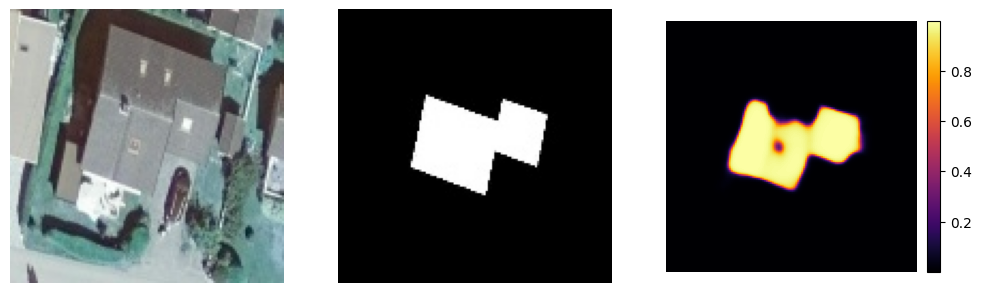

In [37]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable


idx=80
fig, ax = plt.subplots(1, 3, figsize = (12, 12))

ax[0].imshow(img_plot[idx])
ax[0].axis("off")
ax[1].imshow(mask_plot[idx])
ax[1].axis("off")
ax[2].imshow(pred_y_plot[idx])
ax[2].axis("off")
divider = make_axes_locatable(ax[2])
cax2 = divider.append_axes("right", size="5%", pad=0.1)
cb=plt.colorbar(ax[2].imshow(pred_y_plot[idx],cmap = mpl.cm.inferno),cax=cax2)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


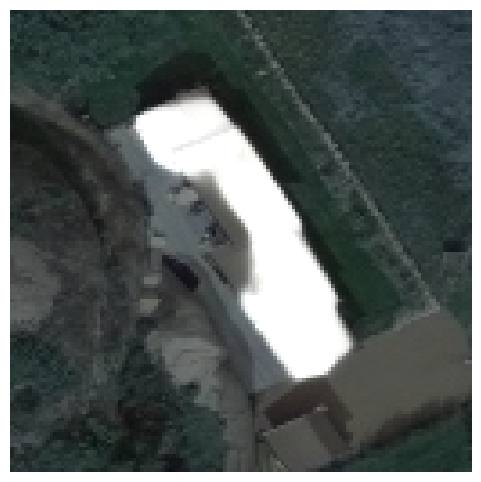

In [4]:
from skimage import img_as_float
from skimage.color import gray2rgb, rgb2gray
from skimage import io
blend = 0.5 * img_as_float(img_plot[idx]) + 0.8 * gray2rgb(img_as_float((pred_y_plot[idx])))
#ADD probability
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
ax.imshow(blend)
ax.axis("off")
plt.show()


[[2.0738675e-04 7.2737923e-05 7.1870614e-05 ... 1.5219010e-04
  1.0610946e-04 4.3631336e-04]
 [7.0343900e-05 3.1069543e-05 3.3613745e-05 ... 1.8659333e-04
  1.2228730e-04 1.9552065e-04]
 [9.5832271e-05 5.4912831e-05 6.6987843e-05 ... 3.3440703e-04
  2.4975752e-04 3.1470996e-04]
 ...
 [7.0187780e-05 3.9745821e-05 7.1059512e-05 ... 1.9673935e-04
  2.4556863e-04 3.1164722e-04]
 [5.9204249e-05 3.0751864e-05 6.1716251e-05 ... 2.4596654e-04
  2.6170808e-04 3.4365477e-04]
 [2.8800749e-04 1.0525910e-04 1.2615479e-04 ... 2.4249767e-04
  2.8168017e-04 6.4803410e-04]]


numpy.ndarray

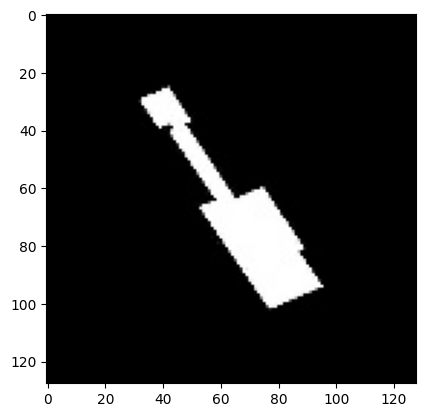

In [5]:
plt.imshow(mask_plot[idx])
print(pred_y_plot[idx])
type(pred_y_plot[idx])

In [6]:
img = mask_plot[idx]
print(np.max(img))

255


(128, 128, 1)


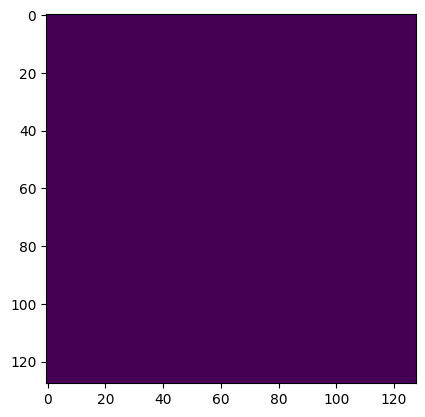

In [7]:
from skimage.color import gray2rgb
img = pred_y_plot[idx]
#img = mask_plot[idx]

#img = gray2rgb(img)
img = img[..., np.newaxis]
image_8bit = np.uint8(img)

shapely_img = image_8bit.copy()
print(img.shape)
plt.imshow(image_8bit)
#img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
contours,hierachy=cv2.findContours(image_8bit,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

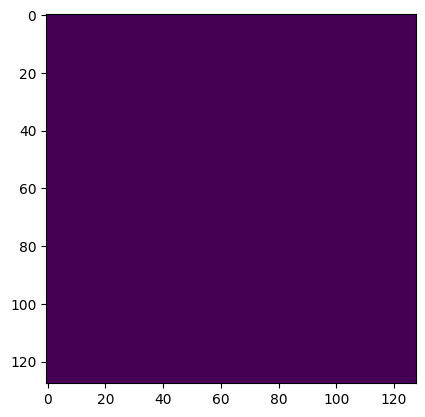

In [8]:
plt.imshow(shapely_img)

In [9]:
cnt = contours[0]
M = cv2.moments(cnt)
print( M )

IndexError: tuple index out of range

In [11]:
cx = int(M['m10']/M['m00'])
cy = int(M['m01']/M['m00'])

NameError: name 'M' is not defined

In [12]:
area = cv2.contourArea(cnt)

NameError: name 'cnt' is not defined

In [13]:
perimeter = cv2.arcLength(cnt,True)

NameError: name 'cnt' is not defined

In [14]:
epsilon = 0.1*cv2.arcLength(cnt,True)
approx = cv2.approxPolyDP(cnt,epsilon,True)

NameError: name 'cnt' is not defined

In [15]:
rect = cv2.minAreaRect(cnt)
box = cv2.boxPoints(rect)
box = np.int0(box)
image_8bit = cv2.drawContours(image_8bit,[box],0,(255,0,0),2)

NameError: name 'cnt' is not defined

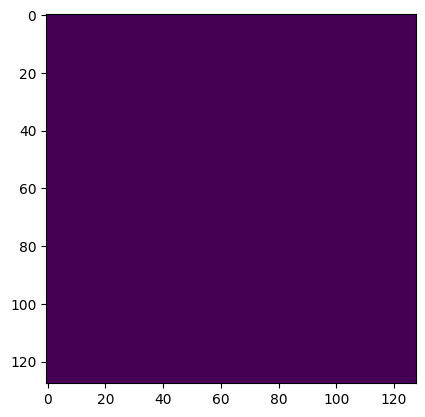

In [16]:
plt.imshow(image_8bit)

In [17]:
hull = cv2.convexHull(cnt)

NameError: name 'cnt' is not defined

In [18]:
cv2.drawContours(image_8bit, [hull], -1, (255,0,0), 3)

NameError: name 'hull' is not defined

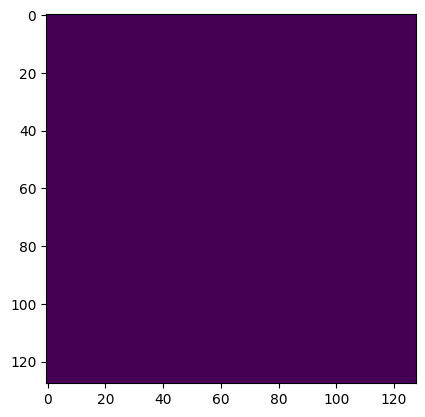

In [19]:
plt.imshow(image_8bit)

In [20]:
cv2.drawContours(image_8bit, [cnt], -1, (255,0,0), 5)

NameError: name 'cnt' is not defined

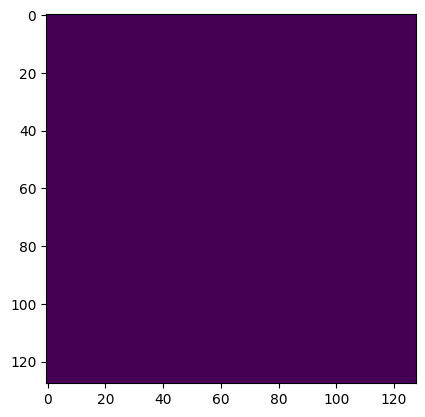

In [21]:
plt.imshow(image_8bit)

In [22]:
# KERNEL KILLER
# import numpy as np
# from scipy.spatial import ConvexHull

# def minimum_bounding_rectangle(points):
#     """
#     Find the smallest bounding rectangle for a set of points.
#     Returns a set of points representing the corners of the bounding box.

#     :param points: an nx2 matrix of coordinates
#     :rval: an nx2 matrix of coordinates
#     """
#     from scipy.ndimage.interpolation import rotate
#     pi2 = np.pi/2.

#     # get the convex hull for the points
#     hull_points = points[ConvexHull(points).vertices]

#     # calculate edge angles
#     edges = np.zeros((len(hull_points)-1, 2))
#     edges = hull_points[1:] - hull_points[:-1]

#     angles = np.zeros((len(edges)))
#     angles = np.arctan2(edges[:, 1], edges[:, 0])

#     angles = np.abs(np.mod(angles, pi2))
#     angles = np.unique(angles)

#     # find rotation matrices
#     # XXX both work
#     rotations = np.vstack([
#         np.cos(angles),
#         np.cos(angles-pi2),
#         np.cos(angles+pi2),
#         np.cos(angles)]).T
# #     rotations = np.vstack([
# #         np.cos(angles),
# #         -np.sin(angles),
# #         np.sin(angles),
# #         np.cos(angles)]).T
#     rotations = rotations.reshape((-1, 2, 2))

#     # apply rotations to the hull
#     rot_points = np.dot(rotations, hull_points.T)

#     # find the bounding points
#     min_x = np.nanmin(rot_points[:, 0], axis=1)
#     max_x = np.nanmax(rot_points[:, 0], axis=1)
#     min_y = np.nanmin(rot_points[:, 1], axis=1)
#     max_y = np.nanmax(rot_points[:, 1], axis=1)

#     # find the box with the best area
#     areas = (max_x - min_x) * (max_y - min_y)
#     best_idx = np.argmin(areas)

#     # return the best box
#     x1 = max_x[best_idx]
#     x2 = min_x[best_idx]
#     y1 = max_y[best_idx]
#     y2 = min_y[best_idx]
#     r = rotations[best_idx]

#     rval = np.zeros((4, 2))
#     rval[0] = np.dot([x1, y2], r)
#     rval[1] = np.dot([x2, y2], r)
#     rval[2] = np.dot([x2, y1], r)
#     rval[3] = np.dot([x1, y1], r)

#     return rval

In [23]:
x = minimum_bounding_rectangle(cnt)

NameError: name 'minimum_bounding_rectangle' is not defined

In [24]:
import rasterio
from rasterio import features
import shapely
from shapely.geometry import Point, Polygon

pred_y_mask = pred_y_plot[idx] > threshold
pred_y_mask = np.array(pred_y_mask, dtype=np.uint8)
pred_y_mask = mask_parse(pred_y_mask)
pred_y_mask=pred_y_mask*255

def mask_to_polygons_layer(mask):
    all_polygons = []
    for shape, value in features.shapes(mask.astype(np.int16), mask=(mask >0), transform=rasterio.Affine(1.0, 0, 0, 0, 1.0, 0)):
        #return shapelyb.geometry.shape(shape)
        all_polygons.append(shapely.geometry.shape(shape))

    all_polygons = shapely.geometry.MultiPolygon(all_polygons)
    if not all_polygons.is_valid:
        all_polygons = all_polygons.buffer(0)
        # Sometimes buffer() converts a simple Multipolygon to just a Polygon,
        # need to keep it a Multi throughout
        if all_polygons.type == 'Polygon':
            all_polygons = shapely.geometry.MultiPolygon([all_polygons])
    return all_polygons

polygons = mask_to_polygons_layer(pred_y_plot[idx]>threshold)

In [25]:
print(polygons[0])

POLYGON ((53 25, 55 25, 55 26, 57 26, 57 27, 58 27, 58 28, 59 28, 59 29, 60 29, 60 31, 61 31, 61 32, 62 32, 62 33, 63 33, 63 34, 64 34, 64 35, 65 35, 65 36, 66 36, 66 38, 67 38, 67 39, 68 39, 68 41, 69 41, 69 42, 70 42, 70 43, 71 43, 71 45, 72 45, 72 47, 73 47, 73 48, 74 48, 74 49, 75 49, 75 51, 76 51, 76 53, 77 53, 77 54, 78 54, 78 56, 79 56, 79 57, 80 57, 80 61, 81 61, 81 64, 82 64, 82 66, 83 66, 83 68, 84 68, 84 69, 85 69, 85 71, 86 71, 86 73, 87 73, 87 74, 88 74, 88 76, 89 76, 89 78, 90 78, 90 86, 91 86, 91 88, 92 88, 92 90, 93 90, 93 92, 94 92, 94 94, 93 94, 93 95, 92 95, 92 96, 91 96, 91 97, 90 97, 90 98, 89 98, 89 99, 88 99, 88 100, 87 100, 87 101, 83 101, 83 102, 79 102, 79 101, 78 101, 78 100, 77 100, 77 99, 76 99, 76 98, 75 98, 75 96, 74 96, 74 95, 73 95, 73 93, 72 93, 72 92, 71 92, 71 90, 70 90, 70 89, 69 89, 69 87, 68 87, 68 86, 67 86, 67 85, 66 85, 66 83, 65 83, 65 79, 66 79, 66 78, 67 78, 67 77, 68 77, 68 66, 67 66, 67 61, 66 61, 66 59, 65 59, 65 58, 64 58, 64 57, 63 57, 

/tmp/ipykernel_6465/2922908944.py:1: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  print(polygons[0])


In [26]:
 roof = polygons[0].exterior.coords.xy

/tmp/ipykernel_6465/3848092091.py:1: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  roof = polygons[0].exterior.coords.xy


In [27]:
roof

(array('d', [53.0, 55.0, 55.0, 57.0, 57.0, 58.0, 58.0, 59.0, 59.0, 60.0, 60.0, 61.0, 61.0, 62.0, 62.0, 63.0, 63.0, 64.0, 64.0, 65.0, 65.0, 66.0, 66.0, 67.0, 67.0, 68.0, 68.0, 69.0, 69.0, 70.0, 70.0, 71.0, 71.0, 72.0, 72.0, 73.0, 73.0, 74.0, 74.0, 75.0, 75.0, 76.0, 76.0, 77.0, 77.0, 78.0, 78.0, 79.0, 79.0, 80.0, 80.0, 81.0, 81.0, 82.0, 82.0, 83.0, 83.0, 84.0, 84.0, 85.0, 85.0, 86.0, 86.0, 87.0, 87.0, 88.0, 88.0, 89.0, 89.0, 90.0, 90.0, 91.0, 91.0, 92.0, 92.0, 93.0, 93.0, 94.0, 94.0, 93.0, 93.0, 92.0, 92.0, 91.0, 91.0, 90.0, 90.0, 89.0, 89.0, 88.0, 88.0, 87.0, 87.0, 83.0, 83.0, 79.0, 79.0, 78.0, 78.0, 77.0, 77.0, 76.0, 76.0, 75.0, 75.0, 74.0, 74.0, 73.0, 73.0, 72.0, 72.0, 71.0, 71.0, 70.0, 70.0, 69.0, 69.0, 68.0, 68.0, 67.0, 67.0, 66.0, 66.0, 65.0, 65.0, 66.0, 66.0, 67.0, 67.0, 68.0, 68.0, 67.0, 67.0, 66.0, 66.0, 65.0, 65.0, 64.0, 64.0, 63.0, 63.0, 62.0, 62.0, 61.0, 61.0, 60.0, 60.0, 59.0, 59.0, 58.0, 58.0, 57.0, 57.0, 56.0, 56.0, 52.0, 52.0, 46.0, 46.0, 44.0, 44.0, 42.0, 42.0, 41.0, 41.

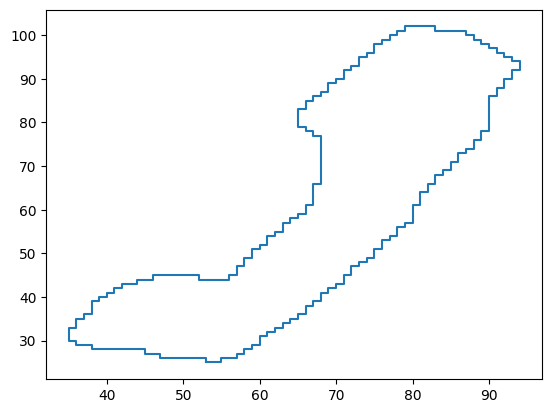

In [28]:
x,y = roof
plt.plot(x,y)

In [29]:
es = polygons[0].buffer(10, join_style=1).buffer(-10.0, join_style=1)

/tmp/ipykernel_6465/2438634618.py:1: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  es = polygons[0].buffer(10, join_style=1).buffer(-10.0, join_style=1)


In [30]:
 roofv2 = es.exterior.coords.xy

(0.0, 128.0)

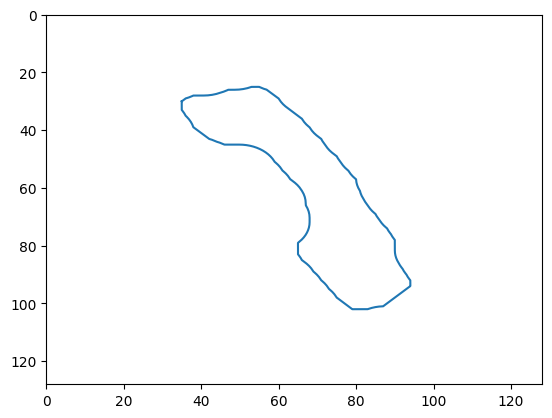

In [31]:
x,y = roofv2
a=plt.plot(x,y)
#plt.ylim(max(y), min(y))
plt.ylim(128, 0)
plt.xlim([0, 128])
#print(roofv2)

ValueError: x and y must have same first dimension, but have shapes (300,) and (311,)

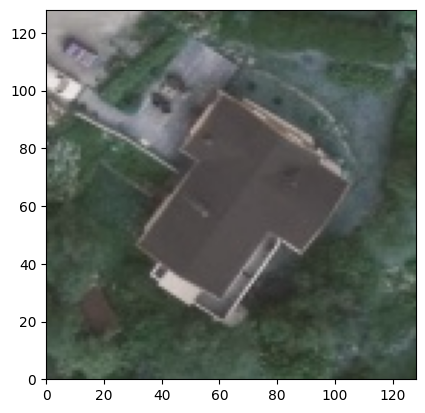

In [99]:
#plt.rcParams["figure.figsize"] = [7.00, 3.50]
#plt.rcParams["figure.autolayout"] = True
fig, ax = plt.subplots()
im = ax.imshow(img_plot[idx], extent=[0, 128, 0, 128])
x = np.array(range(300))
ax.plot(x, y, ls='dotted', linewidth=2, color='red')
plt.show()

array([[[172, 169, 165],
        [173, 170, 166],
        [174, 170, 169],
        ...,
        [ 70, 106,  84],
        [ 67, 103,  79],
        [ 66, 105,  80]],

       [[171, 168, 164],
        [172, 169, 165],
        [172, 168, 167],
        ...,
        [ 68, 101,  80],
        [ 69, 105,  83],
        [ 67, 106,  81]],

       [[169, 165, 164],
        [170, 166, 165],
        [171, 167, 166],
        ...,
        [ 69,  99,  80],
        [ 78, 110,  91],
        [ 83, 119,  97]],

       ...,

       [[ 61,  72,  62],
        [ 61,  72,  62],
        [ 62,  73,  63],
        ...,
        [ 56,  71,  57],
        [ 53,  69,  52],
        [ 47,  63,  46]],

       [[ 64,  72,  65],
        [ 69,  77,  70],
        [ 66,  75,  65],
        ...,
        [ 56,  71,  57],
        [ 54,  67,  51],
        [ 48,  61,  45]],

       [[ 64,  72,  65],
        [ 61,  69,  62],
        [ 64,  73,  63],
        ...,
        [ 53,  68,  54],
        [ 50,  63,  47],
        [ 46,  59,  43]]

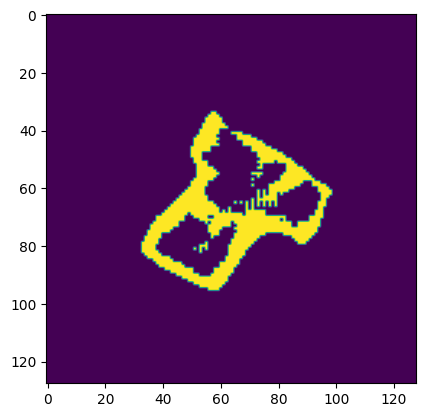

In [87]:
plt.imshow(shapely_img )
img_plot[idx]

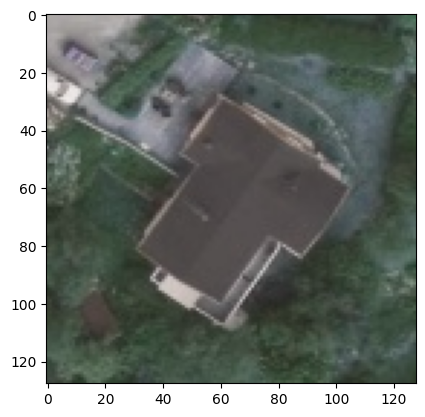

In [88]:
plt.imshow(img_plot[idx])

In [89]:
from skimage import img_as_float
from skimage.color import gray2rgb, rgb2gray
from skimage import io
blend = 0.5 * img_as_float(img_plot[idx]) + 0.8 * gray2rgb(img_as_float((roofv2)))
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
ax.imshow(blend)
ax.axis("off")
plt.show()


ValueError: operands could not be broadcast together with shapes (128,128,3) (2,311,3) 

In [15]:
from skimage.draw import line
def draw_surface(img_org,xx,yy):
    xx,yy = np.asarray(xx,int), np.asarray(yy,int)
    if len(polygons)!=1:
        for j in range(len(polygons)):
            for i in range(len(polygons[j])-1):
                rr, cc = line(polygons[j][i][0],polygons[j][i][1],polygons[j][i+1][0],polygons[j][i+1][1])
                img_org[rr, cc] = (255, 0, 0)
                img_org[rr+1, cc+1] = (255, 0, 0)
    else:
        for i in range(len(xx)-1):
            x1=xx[i]
            y1=yy[i]
            x2=xx[i+1]
            y2=yy[i+1]
            print(x1)
            #rr, cc = line(xx[i],yy[i],xx[i+1],yy[i+1])
            #print(rr,cc)
            rr, cc = line(x1,y1,x2,y2)
            print(type(cc[1]))
            print(rr,cc)
            print(isinstance((rr,cc), tuple))
            img_org[rr, cc] = (255, 0, 0)
            #img_org[rr+1, cc+1] = (255, 0, 0)
            #img_org[rr-1, cc-1] = (255, 0, 0)
    return img_org

In [16]:
img=draw_surface(img_plot,xx,yy)
io.imshow(img)
io.show

NameError: name 'xx' is not defined